# IADT Fase 01 — Tech Challenge

## Previsão de Custos Médicos com Modelos de Regressão

Este notebook documenta o passo a passo para resolver o desafio de previsão de custos médicos, integrando os conhecimentos adquiridos na Fase 01 do curso IADT.

Autor: Victor Nardi Vilella


## 1. Importação das Bibliotecas

Aqui a gente importa as bibliotecas essenciais pra resolver o desafio.  

Cada biblioteca tem seu papel particular: manipular dados, fazer gráficos, modelar e avaliar o modelo.

- `pandas` e `numpy`: manipulação de dados;
- `matplotlib` e `seaborn`: impressão de gráficos pra visualizar melhor os resultados;
- `scikit-learn`: separar os dados, criar o modelo de regressão e avaliar;
- `statsmodels`: pra complementar a validação estatística.

Depois de importadas, seguimos pro carregamento e exploração do dataset.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Carregamento do Dataset

Agora vamos carregar o dataset com os nomes das colunas sugeridas no desafio
  
Primeiro, uma olhada rápida no cabeçalho, na estrutura e nas estatísticas básicas (pra garantir que está tudo certo antes de seguir).

In [30]:
# Carregando o dataset
df = pd.read_csv('../data/insurance.csv')

# Visualizando as primeiras linhas
print("Primeiras linhas do dataset:")
display(df.head())

# Estrutura do DataFrame
print("Informações do dataset:")
df.info()

# Estatísticas
print("Estatísticas:")
display(df.describe())

Primeiras linhas do dataset:


,idade,genero,imc,filhos,fumante,regiao,encargos
0,19,feminino,27.900,0,sim,sudoeste,16884.92400
1,18,masculino,33.770,1,nao,sudeste,1725.55230
2,28,masculino,33.000,3,nao,sudeste,4449.46200
3,33,masculino,22.705,0,nao,noroeste,21984.47061
4,32,masculino,28.880,0,nao,noroeste,3866.85520


Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     1338 non-null   int64  
 1   genero    1338 non-null   object 
 2   imc       1338 non-null   float64
 3   filhos    1338 non-null   int64  
 4   fumante   1338 non-null   object 
 5   regiao    1338 non-null   object 
 6   encargos  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
Estatísticas:


,idade,imc,filhos,encargos
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Comentários - Análise rápida:

Total de registros: 1338

Variáveis categóricas: genero, fumante, regiao

Variáveis numéricas: idade, imc, filhos, encargos

Sem valores ausentes: nos ajuda muito

## 3. Análise Exploratória de Dados (EDA)

Hora de entender melhor a distribuição dos dados e identificar possíveis outliers.

Vamos verificar valores ausentes (mesmo sabendo que não tem), visualizar as distribuições e fazer alguns boxplots.

Valores ausentes por coluna:
idade       0
genero      0
imc         0
filhos      0
fumante     0
regiao      0
encargos    0
dtype: int64


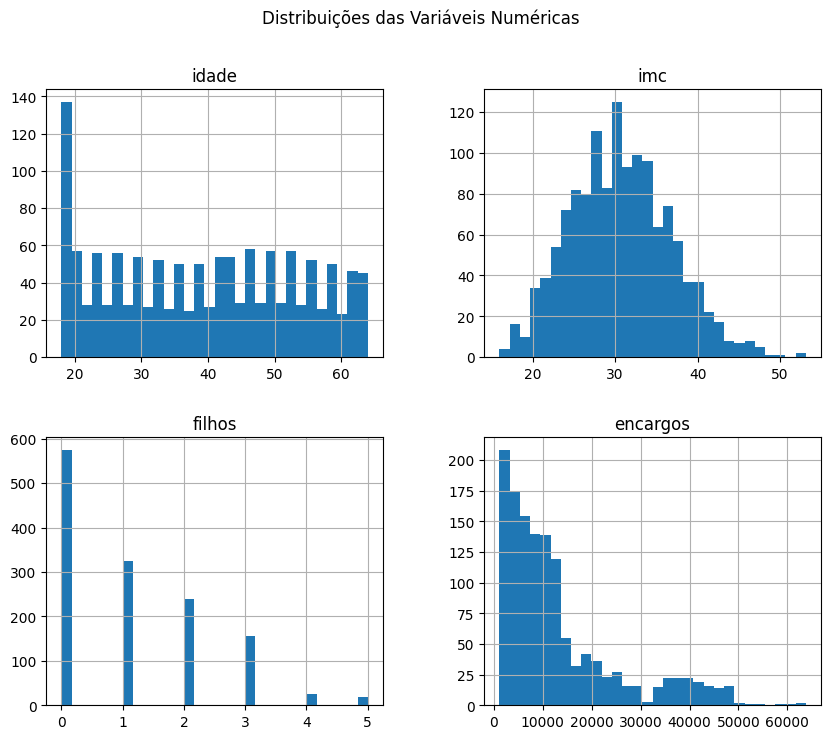

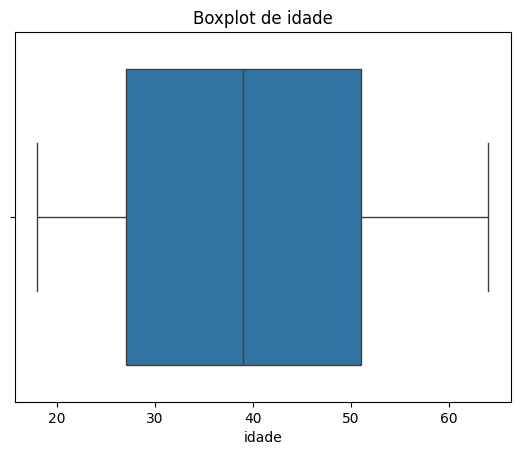

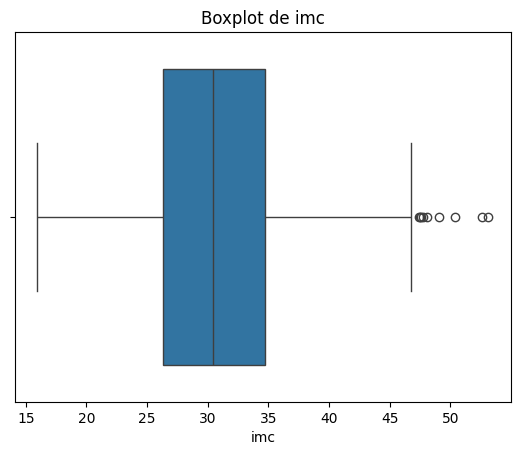

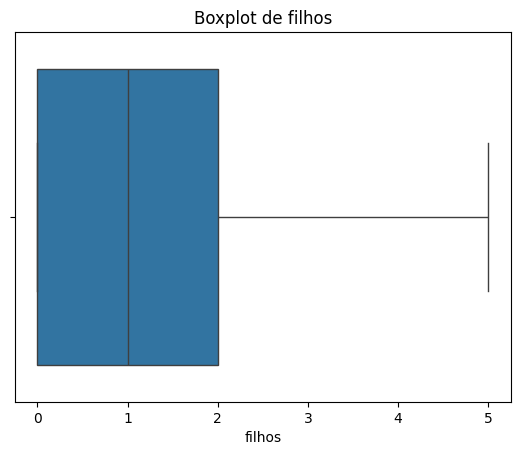

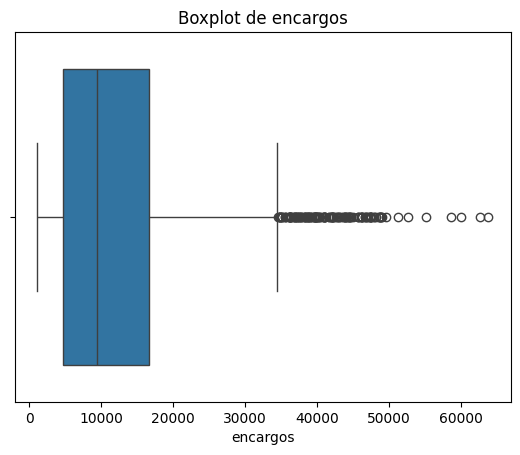

In [31]:
# Verificar se há valores ausentes
print("Valores ausentes por coluna:")
print(df.isnull().sum())

# Histograma das variáveis numéricas
df[['idade', 'imc', 'filhos', 'encargos']].hist(bins=30, figsize=(10,8))
plt.suptitle("Distribuições das Variáveis Numéricas")
plt.show()

# Boxplots para detecção de outliers
for col in ['idade', 'imc', 'filhos', 'encargos']:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

## Interpretação da Análise Exploratória

- **Valores ausentes:** nenhuma coluna com dados faltantes, não precisamos fazer imputação ou remoção.

- **Distribuições:**
  - **Idade:** distribuição uniforme, mais concentrada entre 20 e 40 anos;
  - **IMC:** maioria entre 20 e 40, mas com alguns outliers acima de 45;
  - **Filhos:** maioria com até 2 filhos, poucos casos acima de 3;
  - **Encargos:** distribuição assimétrica — muitos valores baixos.

- **Boxplots:**
  - Mostram presença de **outliers** importantes, principalmente em `imc` e `encargos`.

**Resumo:**  
O dataset está **limpo e pronto** para o pré-processamento;
A presença de outliers será um ponto importante na hora de avaliar o modelo escolhido.

##  4. Pré-processamento dos Dados

Agora precisamos preparar os dados para a modelagem:  
- Transformar variáveis **categóricas** em variáveis numéricas, usando **One-Hot Encoding**.  
- Separar as **variáveis preditoras** (`X`) e a **variável alvo** (`y`), que no nosso caso é `encargos`.


In [32]:
# Transformar variáveis categóricas em dummies
df = pd.get_dummies(df, columns=['genero', 'fumante', 'regiao'], drop_first=True)

print("Colunas após Encoding:")
print(df.columns)

# Separar variáveis preditoras (X) e alvo (y)
X = df.drop('encargos', axis=1)
y = df['encargos']

print("Variáveis preditoras (X):")
display(X.head())

print("Variável alvo (y):")
display(y.head())

Colunas após Encoding:
Index(['idade', 'imc', 'filhos', 'encargos', 'genero_masculino', 'fumante_sim',
       'regiao_noroeste', 'regiao_sudeste', 'regiao_sudoeste'],
      dtype='object')
Variáveis preditoras (X):


,idade,imc,filhos,genero_masculino,fumante_sim,regiao_noroeste,regiao_sudeste,regiao_sudoeste
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False


Variável alvo (y):


0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: encargos, dtype: float64

## Comentários: Transformação das Variáveis Categóricas

Aplicamos **One-Hot Encoding** para transformar as variáveis categóricas (`genero`, `fumante`, `regiao`) em variáveis numéricas binárias.

### Por que fizemos isso?

- Modelos de regressão, como a Regressão Linear, não entendem variáveis categóricas. eles só operam com números;
- O One-Hot Encoding cria colunas binárias (`0` ou `1`) para representar as categorias;
- Isso evita que o modelo interprete, por exemplo, que `masculino` vale mais ou menos que `feminino` só porque o número associado seria maior ou menor;
- Assim, garantimos que o modelo aprenda de forma neutra;

---

### O que mudou no dataset?

- Agora, as variáveis preditoras (`X`) estão todas numéricas e prontas para o modelo.
- A variável alvo (`y`) continua sendo `encargos`, o valor que queremos prever.

**Exemplo de variáveis transformadas:**
- `genero_masculino`: `True` se for masculino, `False` caso contrário.
- `fumante_sim`: `True` se for fumante.
- `regiao_*`: representa as regiões como variáveis binárias.


## 5. Divisão em Conjuntos de Treinamento e Teste

Agora vamos dividir o dataset para treinar e avaliar o modelo.  
Separar os dados evita que o modelo "decore" os exemplos e permite uma avaliação mais realista de sua capacidade de generalização.

Usaremos **80% dos dados para treino** e **20% para teste**.


In [33]:
from sklearn.model_selection import train_test_split

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Treinamento: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")


Treinamento: 1070 amostras
Teste: 268 amostras


## Comentário: Por que dividir o dataset?

Dividimos o dataset em dois conjuntos:

- **Treinamento (80%)**: para o modelo aprender os padrões a partir dos dados.
- **Teste (20%)**: para avaliar se o modelo consegue generalizar para dados que nunca viu.

Essa separação é essencial para evitar o overfitting — quando o modelo "decora" os dados de treino, mas falha ao prever novos casos.

Usamos `random_state=42` para garantir que a divisão seja reprodutível, ou seja, se rodarmos o código novamente, a divisão será a mesma.


## 6. Modelagem Preditiva — Regressão Linear

Agora vamos criar e treinar o nosso modelo de **Regressão Linear**.

Optei por começar com a Regressão Linear por ser um modelo simples, interpretável** e ideal para estabelecer uma linha de base

(Depois, podemos evoluir para modelos mais complexos).


In [34]:
from sklearn.linear_model import LinearRegression

# Inicializar o modelo
modelo = LinearRegression()

# Treinar o modelo com os dados de treino
modelo.fit(X_train, y_train)

print("Modelo treinado com sucesso!")


Modelo treinado com sucesso!


## Explicação do Código — Modelagem com Regressão Linear

- **`modelo = LinearRegression()`**: inicializamos o modelo de Regressão Linear usando a biblioteca scikit-learn.

- **`modelo.fit(X_train, y_train)`**: aqui o modelo aprende a relação entre as variáveis preditoras (`X_train`) e a variável alvo (`y_train`).

**Resumo:**  
Com essas duas linhas de código, o modelo está pronto para fazer previsões com base no que aprendeu a partir dos dados de treinamento.


## 7.Avaliação do Modelo

Agora vamos avaliar a performance do modelo com métricas estatísticas e visualizações.  

As principais métricas que vamos usar são:

- **MSE (Erro Quadrático Médio)**: quanto menor, melhor.
- **RMSE (Raiz do Erro Quadrático Médio)**: interpretação mais intuitiva, na mesma unidade da variável `encargos`.
- **R² (Coeficiente de Determinação)**: indica o quanto da variabilidade do `encargos` é explicada pelo modelo (varia de 0 a 1).

Também vamos visualizar um gráfico de valores reais vs previstos.

MSE: 33596915.85
RMSE: 5796.28
R²: 0.78


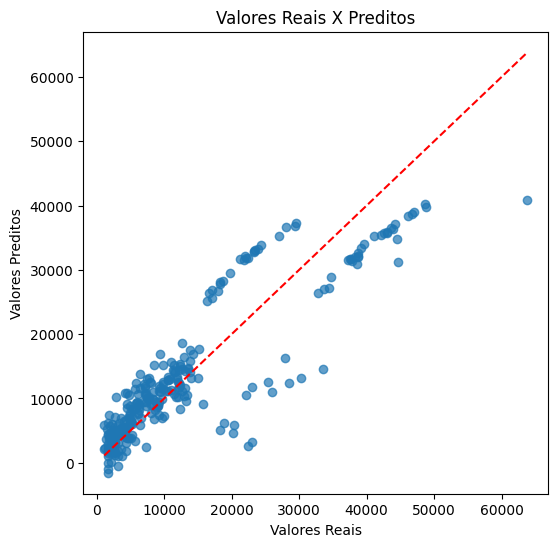

In [35]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Fazer previsões com os dados de teste
y_pred = modelo.predict(X_test)

# Cálculo das métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Gráfico: valores reais X previstos
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais X Preditos')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # linha de referência
plt.show()


## Interpretação das Métricas de Avaliação

### MSE — Erro Quadrático Médio: `33.596.915,85`

- Mede o erro médio ao quadrado entre os valores previstos e os reais.
- Penaliza mais os erros grandes.
- Como os encargos chegam a mais de R$ 60 mil, faz sentido o MSE estar na casa dos milhões.

---

### RMSE — Raiz do Erro Quadrático Médio: `5.796,28`

- É a raiz quadrada do MSE e, por isso, fica na mesma unidade da variável `encargos`.
- Significa que, em média, o modelo erra cerca de R$ 5.800 pra mais ou pra menos.
- Mais intuitivo para explicar a precisão do modelo

---

### R² — Coeficiente de Determinação: `0.78`

- Mede o quanto da variação dos custos médicos o modelo consegue explicar.
- Varia entre 0 e 1:  
  - **1**: modelo perfeito.  
  - **0**: modelo péssimo.  
- Com 0.78, significa que o modelo explica 78% da variação nos encargos.

---

### **Resumo:**

Nosso modelo:  
- Tem um erro médio de cerca de R$ 5.800.  
- Explica 78% dos fatores que influenciam os custos médicos.

É um resultado satisfatório, principalmente para um modelo simples.


## 8. Validação Estatística com `statsmodels`

Agora faremos uso do pacote `statsmodels` para fazer uma validação estatística mais completa.  
Diferente do `scikit-learn`, o `statsmodels` nos permite analisar:

- **p-valores**: verificar a significância de cada variável;
- **intervalos de confiança**: entender a precisão dos coeficientes estimados;
- **resumo completo** do modelo: com várias estatísticas úteis para interpretação.

Isso é importante para validar a robustez do modelo e garantir que as variáveis realmente contribuem para explicar o `encargos`.


In [36]:
import statsmodels.api as sm

# Garantir que todas as variáveis são numéricas
X = X.astype(float)

# Adicionar a constante para o intercepto
X2 = sm.add_constant(X)

# Ajustar o modelo com statsmodels
modelo_stats = sm.OLS(y, X2).fit()

# Exibir o resumo estatístico
print(modelo_stats.summary())


                            OLS Regression Results                            
Dep. Variable:               encargos   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        23:49:51   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819  

## Resumo da Validação Estatística

Rodamos a validação com `statsmodels` e o que a gente viu?

- O modelo conseguiu explicar cerca de **75%** da variação nos custos médicos → isso é **bom** pra um modelo simples como a Regressão Linear.

- Algumas variáveis se mostraram*bem importantes
  - Ser fumante aumenta, em média, o custo médico em mais de R$ 23 mil (faz muito sentido);
  - Quanto maior o IMC e a idade, maior também o custo.
  - Ter filhos também aumenta um pouco o custo.

- Outras variáveis não foram tão importantes**:
  - Por exemplo, o gênero (ser homem ou mulher) não teve um impacto estatisticamente significativo.
  - A região noroeste também não se destacou.


**Resumo da ópera:**  
O modelo funciona bem, identifica variáveis-chave e ainda dá pra evoluir testando modelos mais complexos ou refinando as variáveis.


## Conclusão e Próximos Passos

Finalizamos nosso modelo de **Regressão Linear** para prever os **custos médicos** com base em características pessoais.

### O que conseguimos até aqui:

- Fizemos toda a exploração dos dados, identificando outliers e padrões.
- Transformamos variáveis categóricas com One-Hot Encoding.
- Treinamos um modelo de Regressão Linear.
- Avaliamos o desempenho: com um R² de ~75% (bom resultado)
- Fizemos uma validação estatística completa, confirmando que variáveis como fumante, idade e IMC são as que mais impactam no custo.

---

### Próximos passos possíveis:

- Testar modelos mais complexos: como Árvores de Decisão;
- Fazer ajuste de hiperparâmetros para melhorar a performance.

---

### **Resumo final:**

Modelo rodou bem, resultado consistente e explicável.  
Deu pra aplicar na prática vários conceitos que vimos nas aulas:  
- Pré-processamento,  
- Modelagem,  
- Avaliação,  
- Validação estatística.  

## Extra 02: Teste com Árvore de Decisão Regressora

### 2.1 Inicializar a árvore de decisão

Agora vamos testar outro modelo: **Árvore de Decisão Regressora**.  
A ideia do modelo é que consegue capturar relações não lineares que a Regressão Linear não pega.
O objetivo aqui é comparar os resultados e ver se melhora ou piora a performance.


In [37]:
from sklearn.tree import DecisionTreeRegressor

# Inicializando a Árvore de Decisão
modelo_arvore = DecisionTreeRegressor(random_state=42)

print("Modelo Árvore de Decisão inicializado!")


Modelo Árvore de Decisão inicializado!


### 2.2 Treinamento e Previsão

Agora vamos treinar o modelo de Árvore de Decisão com os dados de treino e depois fazer as previsões

Assim como fizemos com a Regressão Linear, a ideia aqui é ver como esse modelo se comporta com os dados e se ele melhora ou piora a nossa previsão.

Vamos treinar e depois avaliar!


In [38]:
# Treinando o modelo com os dados de treino
modelo_arvore.fit(X_train, y_train)

# Fazendo previsões
y_pred_arvore = modelo_arvore.predict(X_test)

print("Modelo treinado e previsões realizadas!")


Modelo treinado e previsões realizadas!


### 2.3 Avaliação do Modelo de Árvore de Decisão

Agora vamos **avaliar a performance** da Árvore de Decisão utilizando as mesmas métricas que usamos na Regressão Linear:

- **MSE (Erro Quadrático Médio)**: mede o erro médio ao quadrado, penalizando mais os erros grandes.  
- **RMSE (Raiz do Erro Quadrático Médio)**: mais intuitivo, na mesma unidade da variável `encargos`.  
- **R² (Coeficiente de Determinação)**: mostra quanto da variação do `encargos` o modelo conseguiu explicar.

Depois de calcular, vamos comparar com os resultados da Regressão Linear e ver qual modelo se saiu melhor.


In [39]:
# Avaliando o modelo
mse_arvore = mean_squared_error(y_test, y_pred_arvore)
rmse_arvore = np.sqrt(mse_arvore)
r2_arvore = r2_score(y_test, y_pred_arvore)

print(f"MSE (Árvore): {mse_arvore:.2f}")
print(f"RMSE (Árvore): {rmse_arvore:.2f}")
print(f"R² (Árvore): {r2_arvore:.2f}")


MSE (Árvore): 42446908.01
RMSE (Árvore): 6515.13
R² (Árvore): 0.73


### Comparação entre Regressão Linear e Árvore de Decisão

Agora que avaliamos os dois modelos, vamos comparar os resultados lado a lado:

| Métrica | Regressão Linear | Árvore de Decisão |
|--------- |----------------- |------------------ |
| **MSE** | ~33.596.916      | ~42.446.908       |
| **RMSE**| ~5.796           | ~6.515            |
| **R²**  | ~0.78            | ~0.73             |

---

### O que esses números nos dizem?

- A **Regressão Linear** teve um desempenho **melhor**:  
  - **Erro menor** (tanto MSE quanto RMSE).  
  - **R² maior**, ou seja, conseguiu explicar **mais da variação** nos custos médicos.

- A **Árvore de Decisão** teve uma performance um pouco **inferior**:  
  - Errou mais na média.  
  - Explicou menos a variação.

---

### Por que isso aconteceu?

- Nem sempre modelos mais complexos, como a Árvore de Decisão, vão ser melhores.  
- Às vezes, a relação entre as variáveis é linear o suficiente para que um modelo mais simples, como a Regressão Linear se saia melhor.  
- Além disso, a Árvore de Decisão pode ter sofrido com overfitting ela tende a se ajustar demais aos dados de treino, e nem sempre generaliza tão bem para dados novos.



### Extra 03: Ajuste manual de hiperparâmetros: Árvore de Decisão

Agora vamos ajustar manualmente o hiperparâmetro `max_depth`, que controla a profundidade da árvore.

Quanto menor a profundidade:  
- Menos complexa: evita overfitting mas pode deixar o modelo subajustado  
Quanto maior:  
- Mais complexa: pode capturar mais padrões, mas corre o risco de overfitting

Vamos testar `max_depth = 3` e ver como o modelo se comporta.


In [40]:
# Inicializando a Árvore de Decisão com max_depth limitado
modelo_arvore_limitada = DecisionTreeRegressor(max_depth=3, random_state=42)

# Treinando o modelo
modelo_arvore_limitada.fit(X_train, y_train)

# Fazendo previsões
y_pred_arvore_limitada = modelo_arvore_limitada.predict(X_test)

# Avaliando o modelo
mse_limitada = mean_squared_error(y_test, y_pred_arvore_limitada)
rmse_limitada = np.sqrt(mse_limitada)
r2_limitada = r2_score(y_test, y_pred_arvore_limitada)

print(f"MSE (Árvore Limitada): {mse_limitada:.2f}")
print(f"RMSE (Árvore Limitada): {rmse_limitada:.2f}")
print(f"R² (Árvore Limitada): {r2_limitada:.2f}")


MSE (Árvore Limitada): 22812669.85
RMSE (Árvore Limitada): 4776.26
R² (Árvore Limitada): 0.85


### Análise: Ajuste manual de hiperparâmetro: `max_depth = 3`

Testei a Árvore de Decisão limitando a **profundidade máxima** para `3` e olha só os resultados:

| Métrica                     | Árvore Original | Árvore Limitada (`max_depth=3`) |
|---------------------------- |---------------- |---------------------------------|
| **MSE**                    | ~42.446.908     | **~22.812.670** 
| **RMSE**                   | ~6.515          | **~4.776** 
| **R²**                     | ~0.73           | **~0.85**  

---

### Aprendizado

- **Limitar a profundidade** evitou que a árvore ficasse complexa demais, ou seja,**evitou overfitting  
- O modelo generalizou melhor: teve menos erro e explicou mais da variação nos custos médicos.  
- **Melhorou em tudo**: menor MSE, menor RMSE e maior R².

---

### **Resumo:**  

- Nem sempre deixar o modelo maos complexo significa que ele vai ser melhor.  
- Às vezes, um ajuste simples como limitar a profundidade pode fazer uma diferença enorme.  
- Aqui, o modelo ajustado manualmente foi melhor que a Regressão Linear e que a Árvore original!


